In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import shutil
import os

from sklearn.model_selection import train_test_split
import glob

In [76]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns',8000)
pd.set_option('display.max_rows',7000)

In [77]:
train_path='/content/drive/MyDrive/Knee Osteoarthritis/train'
test_path='/content/drive/MyDrive/Knee Osteoarthritis/test'
Val_path='/content/drive/MyDrive/Knee Osteoarthritis/val'

In [78]:
labels=[0,1,2,3,4]

In [93]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob




import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import time
import os
import numpy as np


In [80]:
classes=glob('/content/drive/MyDrive/Knee Osteoarthritis/train/*')

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [82]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,featurewise_center=True,
    samplewise_center=True,featurewise_std_normalization=True,samplewise_std_normalization=True,zca_whitening=True,zca_epsilon=1e-06,
    rotation_range=0.5,width_shift_range=0.3,height_shift_range=0.6,brightness_range=[0.1,0.6],channel_shift_range=0.5,
    fill_mode="nearest",cval=0.0,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [83]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory(Val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [84]:
import tensorflow_addons as tfa

In [85]:
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
metrics = tfa.metrics.F1Score(num_classes = 5,average = "macro",name = "f1_score")
callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=5, mode='max')
reducelr = tf.keras.callbacks.ReduceLROnPlateau( monitor= "val_f1_score",mode='max',factor=0.1,patience=2,verbose=1)

In [86]:
IMAGE_SIZE=[224, 224]

In [87]:
feautre_Ext=InceptionResNetV2(input_shape=IMAGE_SIZE + [3], include_top=False)

219062272/219055592 [==============================] - 2s 0us/step


In [88]:
for layer in feautre_Ext.layers:
    layer.trainable = False

In [94]:
x = Flatten()(feautre_Ext.output)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=feautre_Ext.input, outputs=prediction)

In [95]:
# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [98]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
save_weights_only=True,save_best_only=True,verbose=1,monitor= "val_f1_score",mode='max')

In [104]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[metrics])

In [100]:
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=3600, verbose=0)

In [101]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

181/181 [==============================] - 1711s 9s/step - loss: 2.3561 - f1_score: 0.1277 - val_loss: 2.1613 - val_f1_score: 0.0854

Epoch 00001: val_f1_score improved from -inf to 0.08535, saving model to training_1/cp.ckpt


In [103]:
feau_extractor=DenseNet169(input_shape=IMAGE_SIZE + [3], include_top=False)
for layer in feau_extractor.layers:
    layer.trainable = False
x = Flatten()(feau_extractor.output)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=feau_extractor.input, outputs=prediction)


51879936/51877672 [==============================] - 1s 0us/step


In [105]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

181/181 [==============================] - 1226s 7s/step - loss: 3.4091 - f1_score: 0.1392 - val_loss: 2.7083 - val_f1_score: 0.1343

Epoch 00001: val_f1_score improved from 0.08535 to 0.13430, saving model to training_1/cp.ckpt


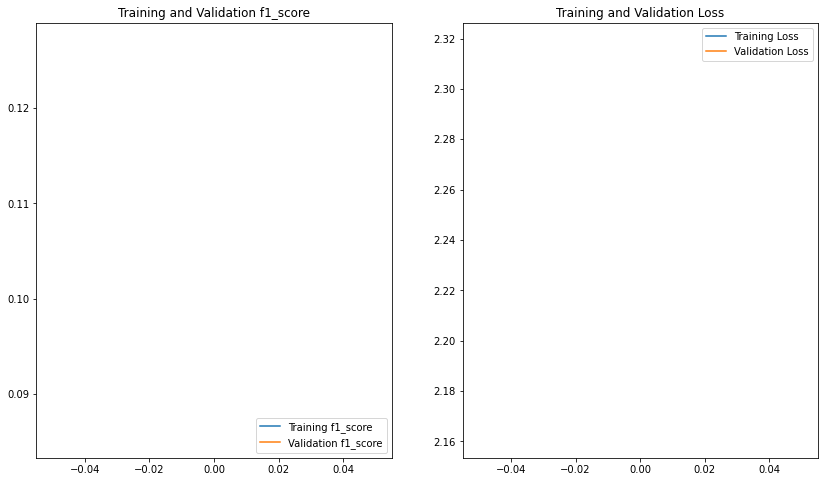

In [102]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 1, 2, 1, 1, 2, 2, 4, 2, 1, 2, 2, 4, 2, 2, 4, 2, 1, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 4, 4, 4,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 4, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2,
       2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 4, 2, 4, 1, 2, 4,
       1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 4, 4, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 2, 1, 4, 4, 4, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 4, 2, 2,
       4, 4, 2, 1, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 2, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
       2, 4, 2, 1, 2, 4, 1, 2, 2, 2, 4, 1, 2, 2, 4,